# Data Cleaning

### Handeling NaNs
Method 1) Dropping NaNs

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
missing_values = ["n/a", "na", "--", "-", " ", "NAN", "nan", "Nan", "NaN"] # Additional NaN possibilities
df = pd.read_csv("archive/aug_train.csv", na_values = missing_values)

In [23]:
# Company Type: Put NaNs into Other
df["company_type"] = df["company_type"].fillna("Other")
df["company_type"].value_counts()

Pvt Ltd                9817
Other                  6261
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Name: company_type, dtype: int64

In [24]:
df["company_size"].value_counts() # 5 938 NaNs. Doesn't make sense to put NaNs into other categories.

50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64

In [25]:
df_dropna = df.dropna()

In [26]:
df["enrollee_id"]

0         8949
1        29725
2        11561
3        33241
4          666
         ...  
19153     7386
19154    31398
19155    24576
19156     5756
19157    23834
Name: enrollee_id, Length: 19158, dtype: int64

In [27]:
df_dropna.isna().values.any()

False

In [28]:
# Label Encoding
len(df) # 19 158 observations
len(df_dropna) # 8 955 observations

9417

### Handling Categorical Values

In [29]:
df_dropna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9417 entries, 1 to 19155
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             9417 non-null   int64  
 1   city                    9417 non-null   object 
 2   city_development_index  9417 non-null   float64
 3   gender                  9417 non-null   object 
 4   relevent_experience     9417 non-null   object 
 5   enrolled_university     9417 non-null   object 
 6   education_level         9417 non-null   object 
 7   major_discipline        9417 non-null   object 
 8   experience              9417 non-null   object 
 9   company_size            9417 non-null   object 
 10  company_type            9417 non-null   object 
 11  last_new_job            9417 non-null   object 
 12  training_hours          9417 non-null   int64  
 13  target                  9417 non-null   float64
dtypes: float64(2), int64(2), object(10)
mem

In [30]:
# Gender
df_dropna = df_dropna[df_dropna.gender != "Other"]
df_dropna2 = df_dropna[df_dropna.gender != "Other"]
df_dropna["gender"] = pd.get_dummies(df_dropna["gender"])["Male"].astype("int64") # 1: Male, 8073. 0: Female, 804.

# Relevant Experience
# df_dropna["relevent_experience"] = pd.get_dummies(df_dropna["relevent_experience"])["Has relevent experience"].astype("int64") # 1: Has relevant experience, 7798. 0: No relevant experience, 1079.

# Enrolled in University
#df_dropna["enrolled_university"] = df_dropna["enrolled_university"].astype('category')
#df_dropna["enrolled_university"] = df_dropna["enrolled_university"].cat.codes.astype("int64")

In [31]:
for column in df_dropna.columns:
    if df_dropna[column].dtype == "object":
        df_dropna[column] = df_dropna[column].astype("category")
        df_dropna[column] = df_dropna[column].cat.codes.astype("int64")

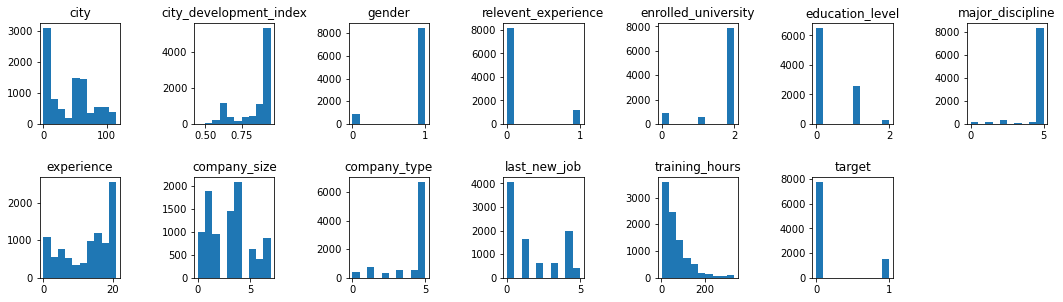

In [32]:
fig = plt.figure(figsize = (15, 15), edgecolor="k")

for i in range(1, df_dropna.shape[1]):
    plt.subplot(df_dropna.shape[1]/2, df_dropna.shape[1]/2, i)
    plt.hist(df_dropna.iloc[:,i])
    plt.title(df_dropna.columns[i])

fig.tight_layout(pad=2.0)
plt.show()

In [33]:
#sns.pairplot(df_dropna)

In [34]:
# Renaming relevant_experience
df_dropna = df_dropna.rename(columns={"relevent_experience": "relevant_experience"})

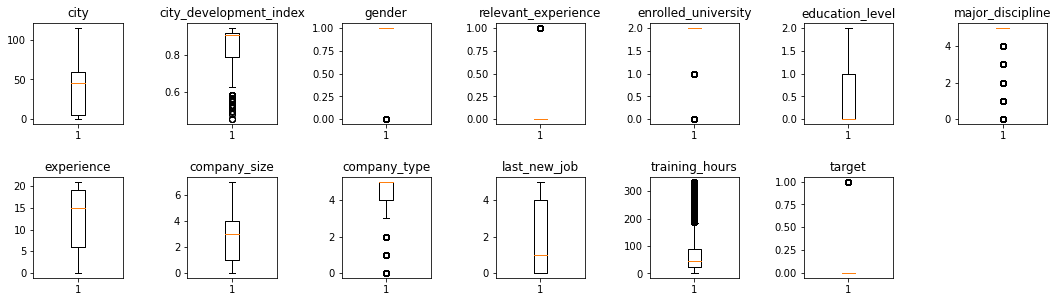

In [35]:
fig = plt.figure(figsize = (15, 15), edgecolor="k")

for i in range(1, df_dropna.shape[1]):
    plt.subplot(df_dropna.shape[1]/2, df_dropna.shape[1]/2, i)
    plt.boxplot(df_dropna.iloc[:,i])
    plt.title(df_dropna.columns[i])

fig.tight_layout(pad=2.0)
plt.show()

In [36]:
#sorted(df_dropna["training_hours"].unique(), reverse=True)

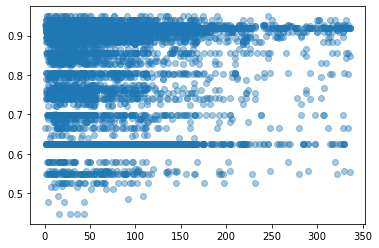

In [37]:
plt.scatter(df_dropna["training_hours"], df_dropna["city_development_index"], alpha=0.4)

### Balancing

In [38]:
df_dropna["target"].value_counts()

0.0    7790
1.0    1540
Name: target, dtype: int64

In [39]:
df_dropna_sample = df_dropna[df_dropna["target"] == 0.0].sample(n=3000, random_state=42)

In [40]:
df_dropna_bal = df_dropna[df_dropna["target"] == 1.0].append(df_dropna_sample)

In [41]:
df_dropna_bal["target"].value_counts()

0.0    3000
1.0    1540
Name: target, dtype: int64

# Testing Random Forest

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics

In [43]:
X = df_dropna_bal.iloc[:,1:13]
y = df_dropna_bal.iloc[:, 13]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [44]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [45]:
print(metrics.classification_report(y_test, y_pred)) # 0.71 accuracy, 0.61 recall for 1

              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85       616
         1.0       0.75      0.49      0.59       292

    accuracy                           0.78       908
   macro avg       0.77      0.71      0.72       908
weighted avg       0.78      0.78      0.77       908



# Testing SVM

In [46]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [47]:
clf_svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [48]:
clf_svm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [49]:
y_pred_svm = clf.predict(X_test)

In [50]:
print(metrics.classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

         0.0       0.79      0.92      0.85       616
         1.0       0.75      0.49      0.59       292

    accuracy                           0.78       908
   macro avg       0.77      0.71      0.72       908
weighted avg       0.78      0.78      0.77       908



In [51]:
df["relevent_experience"].value_counts()

Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64

In [52]:
df_dropna["company_type"].value_counts()

5    6738
1     775
4     559
3     524
0     382
2     352
Name: company_type, dtype: int64